In [175]:
import gym
import torch
from torch import nn
from collections import defaultdict

class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_fc = nn.Linear(4, 128)
        self.actor_fc = nn.Linear(128, 2)
        self.value_fc = nn.Linear(128, 1)
        
    def forward(self, x):
        x = torch.relu(self.base_fc(x))
        prob = torch.softmax(self.actor_fc(x), dim=0)
        value = self.value_fc(x)
        return prob, value

    def critic(self, x):
        x = torch.relu(self.base_fc(x))
        value = self.value_fc(x)
        return value
    
    def sample_action(self, x):
        m = torch.distributions.Categorical(x)
        return m.sample().item()


In [176]:
       
env = gym.make("CartPole-v1")
pi = Policy()
gamma = 0.95
lr = 0.001
n_step = 5


optimizer = torch.optim.Adam(pi.parameters(), lr=lr)
rewards = []
losses = defaultdict(list)

In [179]:

for epi in range(2000):
    
    state = env.reset()
    data = []
    counter = 0
    while True:
        prob, value = pi(torch.from_numpy(state).float())
        action = pi.sample_action(prob)
        state, reward, done, info = env.step(action)
        data.append([prob[action], reward, value])
        counter += 1
        if done or (epi+1)%n_step:
            
            if done:
                R = 0
            else:
                R = pi.critic(torch.from_numpy(state).float())

            optimizer.zero_grad()
            for p, r, v in data[::-1]:
                R = r + gamma * R
                actor_loss = - (R - v.detach()) * torch.log(p)
                critic_loss = (R - v)**2
                loss = actor_loss + critic_loss
                loss.backward()
                
                losses['actor_loss'].append(actor_loss.item())
                losses['critic_loss'].append(critic_loss.item())
            nn.utils.clip_grad_norm_(pi.parameters(), 1)
            optimizer.step()
            data = []
            
            if done:
                break
            
    rewards.append(counter)


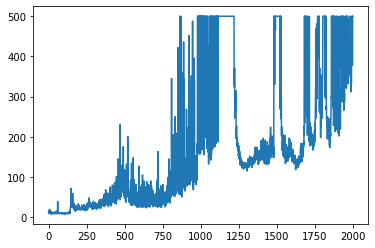

In [180]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(rewards)

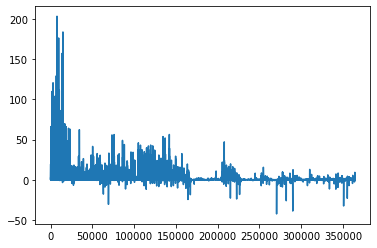

In [181]:
plt.plot(losses['actor_loss'])

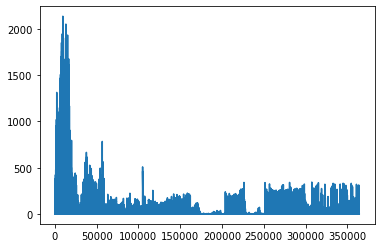

In [182]:
plt.plot(losses['critic_loss'])